In [4]:
import pandas as pd
from sklearn.model_selection import train_test_split

# Load the dataset
data = pd.read_csv('../data/cleaned_financial_data.csv', parse_dates=['Date'], index_col='Date')

# Use closing prices and additional features for forecasting
features = ['Close_TSLA', 'Volume_TSLA', 'High_TSLA', 'Low_TSLA']
data_tsla = data[features]

# Divide the dataset into training and testing sets
train_data, test_data = train_test_split(data_tsla, test_size=0.2, shuffle=False)


In [5]:
from statsmodels.tsa.arima.model import ARIMA

# Train ARIMA model on closing prices
arima_model = ARIMA(train_data['Close_TSLA'], order=(5, 1, 0))  # You might need to tune the order
arima_model_fit = arima_model.fit()


/home/enat/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enat/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/home/enat/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


In [7]:
forecast_arima = arima_model_fit.forecast(steps=len(test_data))


/home/enat/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/home/enat/.local/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [8]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

# Create sequences for LSTM
def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data) - seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length, 0]  # predict the Close_TSLA
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 60  # 60 days sequence
X_train, y_train = create_sequences(train_scaled, seq_length)
X_test, y_test = create_sequences(test_scaled, seq_length)


In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build the LSTM model

model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

# Train the model
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2)


2025-03-03 22:22:56.672291: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-03 22:22:56.683020: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 22:22:56.698423: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-03 22:22:56.705844: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741029776.718866   21379 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741029776.72

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 60, 50)         │        11,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 31,251 (122.07 KB)

 Trainable params: 31,251 (122.07 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 4s 40ms/step - loss: 0.0104 - val_loss: 0.0041
Epoch 2/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 7.6015e-04 - val_loss: 0.0064
Epoch 3/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 5.8815e-04 - val_loss: 0.0038
Epoch 4/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 8.3338e-04 - val_loss: 0.0047
Epoch 5/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 7.3323e-04 - val_loss: 0.0036
Epoch 6/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 8.2154e-04 - val_loss: 0.0031
Epoch 7/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 4.9770e-04 - val_loss: 0.0032
Epoch 8/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 4.8376e-04 - val_loss: 0.0028
Epoch 9/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 5.5037e-04 - val_loss: 0.0035
Epoch 10/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 4.6780e-04 - val_loss: 0.0026
Epoch 11/20
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 4.9767e-04 - val_loss: 0.0025
Epoch 12/20
50/50 ━━━━━

In [11]:
predictions_lstm = model.predict(X_test)
predictions_lstm = scaler.inverse_transform(np.concatenate((predictions_lstm, np.zeros((predictions_lstm.shape[0], len(features) - 1))), axis=1))[:, 0]


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


In [12]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# ARIMA Metrics
mae_arima = mean_absolute_error(test_data['Close_TSLA'], forecast_arima)
rmse_arima = np.sqrt(mean_squared_error(test_data['Close_TSLA'], forecast_arima))
mape_arima = mean_absolute_percentage_error(test_data['Close_TSLA'], forecast_arima)

print(f"ARIMA - Mean Absolute Error (MAE): {mae_arima}")
print(f"ARIMA - Root Mean Squared Error (RMSE): {rmse_arima}")
print(f"ARIMA - Mean Absolute Percentage Error (MAPE): {mape_arima}")

# LSTM Metrics
mae_lstm = mean_absolute_error(test_data['Close_TSLA'][seq_length:], predictions_lstm)
rmse_lstm = np.sqrt(mean_squared_error(test_data['Close_TSLA'][seq_length:], predictions_lstm))
mape_lstm = mean_absolute_percentage_error(test_data['Close_TSLA'][seq_length:], predictions_lstm)

print(f"LSTM - Mean Absolute Error (MAE): {mae_lstm}")
print(f"LSTM - Root Mean Squared Error (RMSE): {rmse_lstm}")
print(f"LSTM - Mean Absolute Percentage Error (MAPE): {mape_lstm}")


ARIMA - Mean Absolute Error (MAE): 89.80228002979669
ARIMA - Root Mean Squared Error (RMSE): 110.98932205985729
ARIMA - Mean Absolute Percentage Error (MAPE): 0.3456593520094358
LSTM - Mean Absolute Error (MAE): 12.039023631014688
LSTM - Root Mean Squared Error (RMSE): 17.600963487095452
LSTM - Mean Absolute Percentage Error (MAPE): 0.047188943391724386


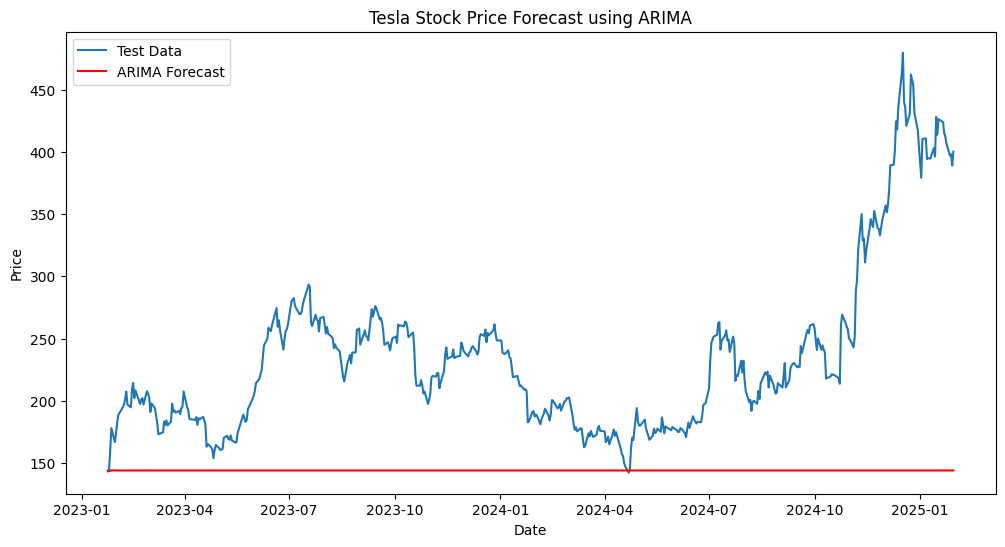

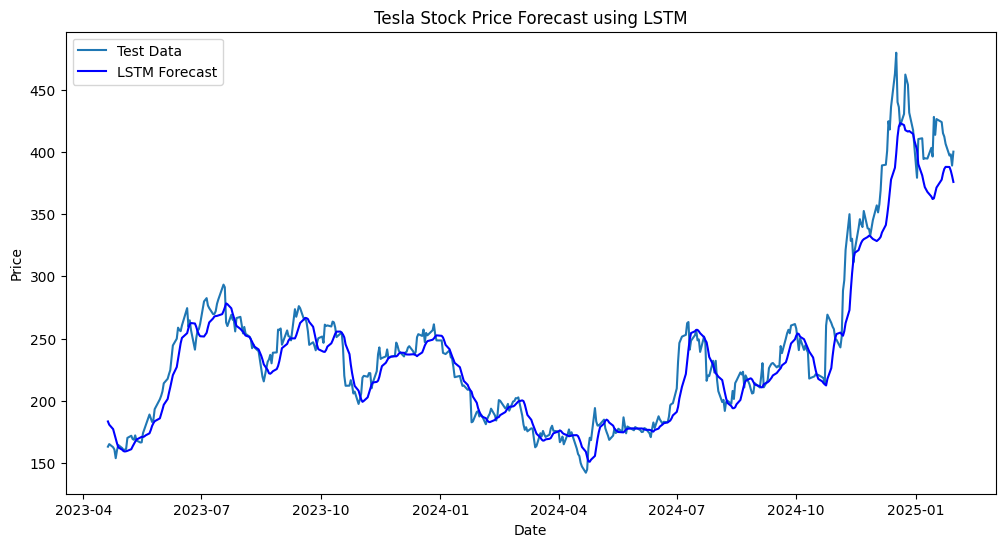

In [13]:
import matplotlib.pyplot as plt

# Plot ARIMA Results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_data['Close_TSLA'], label='Test Data')
plt.plot(test_data.index, forecast_arima, label='ARIMA Forecast', color='red')
plt.title('Tesla Stock Price Forecast using ARIMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# Plot LSTM Results
plt.figure(figsize=(12, 6))
plt.plot(test_data.index[seq_length:], test_data['Close_TSLA'][seq_length:], label='Test Data')
plt.plot(test_data.index[seq_length:], predictions_lstm, label='LSTM Forecast', color='blue')
plt.title('Tesla Stock Price Forecast using LSTM')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()
